Preprocessing Anime dataset from Kaggle

In [12]:
from collections import defaultdict
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import re
import string

1. Data preprocessing

1.1 Data Cleaning

In [13]:
# remove unwanted features (columns) from the dataset
anime_df = pd.read_csv("animes.csv")
anime_df.rename(columns={'title': 'name'}, inplace=True)
anime_df.drop(['aired', 'ranked', 'img_url', 'link'], axis=1, inplace=True)

#removing unwanted characters from the anime name strings
def text_cleaning(text):
    text = re.sub(r'&quot;', '', text)
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub(r'.hack//', '', text)
    text = re.sub(r'&#039;', '', text)
    text = re.sub(r'A&#039;s', '', text)
    text = re.sub(r'I&#039;', 'I\'', text)
    text = re.sub(r'&amp;', 'and', text)
    text = re.sub(r'Â°', '',text)

    return text

anime_df['name'] = anime_df['name'].apply(text_cleaning)
anime_df.head(5)

,uid,name,synopsis,genre,episodes,members,popularity,score
0,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,"['Comedy', 'Sports', 'Drama', 'School', 'Shoun...",25.0,489888,141,8.82
1,23273,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,"['Drama', 'Music', 'Romance', 'School', 'Shoun...",22.0,995473,28,8.83
2,34599,Made in Abyss,The Abyss—a gaping chasm stretching down into ...,"['Sci-Fi', 'Adventure', 'Mystery', 'Drama', 'F...",13.0,581663,98,8.83
3,5114,Fullmetal Alchemist Brotherhood,"""In order for something to be obtained, someth...","['Action', 'Military', 'Adventure', 'Comedy', ...",64.0,1615084,4,9.23
4,31758,Kizumonogatari III Reiketsuhen,After helping revive the legendary vampire Kis...,"['Action', 'Mystery', 'Supernatural', 'Vampire']",1.0,214621,502,8.83


In [14]:
anime_df.rename(columns={'uid': 'anime_uid'}, inplace=True)
anime_df.episodes.replace({'Unknown':np.nan},inplace=True)

anime_df.head(5)

,anime_uid,name,synopsis,genre,episodes,members,popularity,score
0,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,"['Comedy', 'Sports', 'Drama', 'School', 'Shoun...",25.0,489888,141,8.82
1,23273,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,"['Drama', 'Music', 'Romance', 'School', 'Shoun...",22.0,995473,28,8.83
2,34599,Made in Abyss,The Abyss—a gaping chasm stretching down into ...,"['Sci-Fi', 'Adventure', 'Mystery', 'Drama', 'F...",13.0,581663,98,8.83
3,5114,Fullmetal Alchemist Brotherhood,"""In order for something to be obtained, someth...","['Action', 'Military', 'Adventure', 'Comedy', ...",64.0,1615084,4,9.23
4,31758,Kizumonogatari III Reiketsuhen,After helping revive the legendary vampire Kis...,"['Action', 'Mystery', 'Supernatural', 'Vampire']",1.0,214621,502,8.83


In [15]:
user_ratings_df = pd.read_csv("reviews.csv")
user_ratings_df.head(5)

,uid,profile,anime_uid,text,score,scores,link
0,255938,DesolatePsyche,34096,\n \n \n \n ...,8,"{'Overall': '8', 'Story': '8', 'Animation': '8...",https://myanimelist.net/reviews.php?id=255938
1,259117,baekbeans,34599,\n \n \n \n ...,10,"{'Overall': '10', 'Story': '10', 'Animation': ...",https://myanimelist.net/reviews.php?id=259117
2,253664,skrn,28891,\n \n \n \n ...,7,"{'Overall': '7', 'Story': '7', 'Animation': '9...",https://myanimelist.net/reviews.php?id=253664
3,8254,edgewalker00,2904,\n \n \n \n ...,9,"{'Overall': '9', 'Story': '9', 'Animation': '9...",https://myanimelist.net/reviews.php?id=8254
4,291149,aManOfCulture99,4181,\n \n \n \n ...,10,"{'Overall': '10', 'Story': '10', 'Animation': ...",https://myanimelist.net/reviews.php?id=291149


1.2 Merging the datasets

In [16]:
# remove unwanted columns
user_ratings_df.drop(['uid', 'link'], axis=1, inplace=True)
user_ratings_df.head(5)

,profile,anime_uid,text,score,scores
0,DesolatePsyche,34096,\n \n \n \n ...,8,"{'Overall': '8', 'Story': '8', 'Animation': '8..."
1,baekbeans,34599,\n \n \n \n ...,10,"{'Overall': '10', 'Story': '10', 'Animation': ..."
2,skrn,28891,\n \n \n \n ...,7,"{'Overall': '7', 'Story': '7', 'Animation': '9..."
3,edgewalker00,2904,\n \n \n \n ...,9,"{'Overall': '9', 'Story': '9', 'Animation': '9..."
4,aManOfCulture99,4181,\n \n \n \n ...,10,"{'Overall': '10', 'Story': '10', 'Animation': ..."


In [17]:
# change profile names into unique IDs (i.e. integers)
user_ratings_df.profile = pd.factorize(user_ratings_df.profile)[0]
user_ratings_df.rename(columns={'profile': 'user_id'}, inplace=True)
user_ratings_df.head(10)

,user_id,anime_uid,text,score,scores
0,0,34096,\n \n \n \n ...,8,"{'Overall': '8', 'Story': '8', 'Animation': '8..."
1,1,34599,\n \n \n \n ...,10,"{'Overall': '10', 'Story': '10', 'Animation': ..."
2,2,28891,\n \n \n \n ...,7,"{'Overall': '7', 'Story': '7', 'Animation': '9..."
3,3,2904,\n \n \n \n ...,9,"{'Overall': '9', 'Story': '9', 'Animation': '9..."
4,4,4181,\n \n \n \n ...,10,"{'Overall': '10', 'Story': '10', 'Animation': ..."
5,5,2904,\n \n \n \n ...,10,"{'Overall': '10', 'Story': '9', 'Animation': '..."
6,6,16664,\n \n \n \n ...,6,"{'Overall': '6', 'Story': '6', 'Animation': '9..."
7,7,2904,\n \n \n \n ...,8,"{'Overall': '8', 'Story': '7', 'Animation': '9..."
8,8,2904,\n \n \n \n ...,10,"{'Overall': '10', 'Story': '10', 'Animation': ..."
9,9,4181,\n \n \n \n ...,4,"{'Overall': '4', 'Story': '8', 'Animation': '9..."


In [18]:
merged_anime_reviews_df = pd.merge(anime_df, user_ratings_df, on='anime_uid')
merged_anime_reviews_df.rename(columns={'score_x':'avg_rating', 'text': 'review_text'},inplace=True)

merged_anime_reviews_df.drop('review_text', axis=1, inplace=True)

merged_anime_reviews_df.head()

,anime_uid,name,synopsis,genre,episodes,members,popularity,avg_rating,user_id,score_y,scores
0,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,"['Comedy', 'Sports', 'Drama', 'School', 'Shoun...",25.0,489888,141,8.82,2,7,"{'Overall': '7', 'Story': '7', 'Animation': '9..."
1,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,"['Comedy', 'Sports', 'Drama', 'School', 'Shoun...",25.0,489888,141,8.82,15102,10,"{'Overall': '10', 'Story': '10', 'Animation': ..."
2,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,"['Comedy', 'Sports', 'Drama', 'School', 'Shoun...",25.0,489888,141,8.82,15103,10,"{'Overall': '10', 'Story': '10', 'Animation': ..."
3,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,"['Comedy', 'Sports', 'Drama', 'School', 'Shoun...",25.0,489888,141,8.82,13930,7,"{'Overall': '7', 'Story': '7', 'Animation': '7..."
4,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,"['Comedy', 'Sports', 'Drama', 'School', 'Shoun...",25.0,489888,141,8.82,599,8,"{'Overall': '8', 'Story': '7', 'Animation': '7..."


Categorical encoding -> Separating genres into their own respective column

In [19]:
# replace the characters "[]'" with an empty space as the genre column is already of type string
merged_anime_reviews_df['genre'] = [merged_anime_reviews_df['genre'][0].translate(
    {ord(i): "" for i in "[]'"}) for anime in merged_anime_reviews_df['genre']]

merged_anime_reviews_df.head(5)

,anime_uid,name,synopsis,genre,episodes,members,popularity,avg_rating,user_id,score_y,scores
0,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,"Comedy, Sports, Drama, School, Shounen",25.0,489888,141,8.82,2,7,"{'Overall': '7', 'Story': '7', 'Animation': '9..."
1,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,"Comedy, Sports, Drama, School, Shounen",25.0,489888,141,8.82,15102,10,"{'Overall': '10', 'Story': '10', 'Animation': ..."
2,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,"Comedy, Sports, Drama, School, Shounen",25.0,489888,141,8.82,15103,10,"{'Overall': '10', 'Story': '10', 'Animation': ..."
3,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,"Comedy, Sports, Drama, School, Shounen",25.0,489888,141,8.82,13930,7,"{'Overall': '7', 'Story': '7', 'Animation': '7..."
4,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,"Comedy, Sports, Drama, School, Shounen",25.0,489888,141,8.82,599,8,"{'Overall': '8', 'Story': '7', 'Animation': '7..."


In [20]:
# separate genres into separate columns, with a maximum of 5 different genres to limit the dimensions of the dataframe
genres = merged_anime_reviews_df['genre'].str.split(",", expand=True)
genres = genres.iloc[:,:5]
genres.columns = ['genre1', 'genre2', 'genre3','genre4', 'genre5']

genres.head(10)

,genre1,genre2,genre3,genre4,genre5
0,Comedy,Sports,Drama,School,Shounen
1,Comedy,Sports,Drama,School,Shounen
2,Comedy,Sports,Drama,School,Shounen
3,Comedy,Sports,Drama,School,Shounen
4,Comedy,Sports,Drama,School,Shounen
5,Comedy,Sports,Drama,School,Shounen
6,Comedy,Sports,Drama,School,Shounen
7,Comedy,Sports,Drama,School,Shounen
8,Comedy,Sports,Drama,School,Shounen
9,Comedy,Sports,Drama,School,Shounen


In [21]:
merged_anime_reviews_df.drop(columns='genre', axis=1, inplace=True)
merged_anime_reviews_df = pd.concat([merged_anime_reviews_df, genres], axis=1)

merged_anime_reviews_df.head()

,anime_uid,name,synopsis,episodes,members,popularity,avg_rating,user_id,score_y,scores,genre1,genre2,genre3,genre4,genre5
0,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,25.0,489888,141,8.82,2,7,"{'Overall': '7', 'Story': '7', 'Animation': '9...",Comedy,Sports,Drama,School,Shounen
1,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,25.0,489888,141,8.82,15102,10,"{'Overall': '10', 'Story': '10', 'Animation': ...",Comedy,Sports,Drama,School,Shounen
2,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,25.0,489888,141,8.82,15103,10,"{'Overall': '10', 'Story': '10', 'Animation': ...",Comedy,Sports,Drama,School,Shounen
3,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,25.0,489888,141,8.82,13930,7,"{'Overall': '7', 'Story': '7', 'Animation': '7...",Comedy,Sports,Drama,School,Shounen
4,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,25.0,489888,141,8.82,599,8,"{'Overall': '8', 'Story': '7', 'Animation': '7...",Comedy,Sports,Drama,School,Shounen


Separating the Scores column

In [22]:
merged_anime_reviews_df['scores'] = [merged_anime_reviews_df['scores'][0].translate({ord(i): "" for i in "{}'"}) for anime in merged_anime_reviews_df['scores']]

merged_anime_reviews_df.head(5)

,anime_uid,name,synopsis,episodes,members,popularity,avg_rating,user_id,score_y,scores,genre1,genre2,genre3,genre4,genre5
0,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,25.0,489888,141,8.82,2,7,"Overall: 7, Story: 7, Animation: 9, Sound: 8, ...",Comedy,Sports,Drama,School,Shounen
1,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,25.0,489888,141,8.82,15102,10,"Overall: 7, Story: 7, Animation: 9, Sound: 8, ...",Comedy,Sports,Drama,School,Shounen
2,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,25.0,489888,141,8.82,15103,10,"Overall: 7, Story: 7, Animation: 9, Sound: 8, ...",Comedy,Sports,Drama,School,Shounen
3,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,25.0,489888,141,8.82,13930,7,"Overall: 7, Story: 7, Animation: 9, Sound: 8, ...",Comedy,Sports,Drama,School,Shounen
4,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,25.0,489888,141,8.82,599,8,"Overall: 7, Story: 7, Animation: 9, Sound: 8, ...",Comedy,Sports,Drama,School,Shounen


In [23]:
merged_anime_reviews_df['scores'] = [re.sub("[^0-9,]", "", anime) for anime in merged_anime_reviews_df['scores']]
merged_anime_reviews_df.head()

,anime_uid,name,synopsis,episodes,members,popularity,avg_rating,user_id,score_y,scores,genre1,genre2,genre3,genre4,genre5
0,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,25.0,489888,141,8.82,2,7,"7,7,9,8,8,8",Comedy,Sports,Drama,School,Shounen
1,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,25.0,489888,141,8.82,15102,10,"7,7,9,8,8,8",Comedy,Sports,Drama,School,Shounen
2,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,25.0,489888,141,8.82,15103,10,"7,7,9,8,8,8",Comedy,Sports,Drama,School,Shounen
3,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,25.0,489888,141,8.82,13930,7,"7,7,9,8,8,8",Comedy,Sports,Drama,School,Shounen
4,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,25.0,489888,141,8.82,599,8,"7,7,9,8,8,8",Comedy,Sports,Drama,School,Shounen


In [24]:
# Order of columns -> Overall: 7, Story: 7, Animation: 9, Sound: 8, Character: 8, Enjoyment: 8
ratings = merged_anime_reviews_df['scores'].str.split(",", expand=True)
ratings.columns = ['Overall', 'Story', 'Animation','Sound', 'Character', 'Enjoyment']

ratings.head(10)

,Overall,Story,Animation,Sound,Character,Enjoyment
0,7,7,9,8,8,8
1,7,7,9,8,8,8
2,7,7,9,8,8,8
3,7,7,9,8,8,8
4,7,7,9,8,8,8
5,7,7,9,8,8,8
6,7,7,9,8,8,8
7,7,7,9,8,8,8
8,7,7,9,8,8,8
9,7,7,9,8,8,8


In [25]:
merged_anime_reviews_df.drop(['score_y', 'scores'], axis=1, inplace=True)
merged_anime_reviews_df = pd.concat([merged_anime_reviews_df, ratings], axis=1)

merged_anime_reviews_df.head()

,anime_uid,name,synopsis,episodes,members,popularity,avg_rating,user_id,genre1,genre2,genre3,genre4,genre5,Overall,Story,Animation,Sound,Character,Enjoyment
0,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,25.0,489888,141,8.82,2,Comedy,Sports,Drama,School,Shounen,7,7,9,8,8,8
1,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,25.0,489888,141,8.82,15102,Comedy,Sports,Drama,School,Shounen,7,7,9,8,8,8
2,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,25.0,489888,141,8.82,15103,Comedy,Sports,Drama,School,Shounen,7,7,9,8,8,8
3,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,25.0,489888,141,8.82,13930,Comedy,Sports,Drama,School,Shounen,7,7,9,8,8,8
4,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,25.0,489888,141,8.82,599,Comedy,Sports,Drama,School,Shounen,7,7,9,8,8,8


1.3 Deal with missing values

In [26]:
# see how many null values are present within our merged dataframe (merged_anime_reviews_df)
missing_value = pd.DataFrame({
    'Missing Value': merged_anime_reviews_df.isnull().sum()
})
display(missing_value)

,Missing Value
anime_uid,0
name,0
synopsis,904
episodes,2536
members,0
popularity,0
avg_rating,0
user_id,0
genre1,0
genre2,0


In [27]:
# see how many null values are present within our initial dataset (anime_df)
anime_df.isnull().sum()

anime_uid       0
name            0
synopsis      975
genre           0
episodes      706
members         0
popularity      0
score         579
dtype: int64

In [28]:
# remove all null values from both dataframes
merged_anime_reviews_df.dropna(inplace=True)
anime_df.dropna(inplace=True)

merged_anime_reviews_df.isnull().sum()

anime_uid     0
name          0
synopsis      0
episodes      0
members       0
popularity    0
avg_rating    0
user_id       0
genre1        0
genre2        0
genre3        0
genre4        0
genre5        0
Overall       0
Story         0
Animation     0
Sound         0
Character     0
Enjoyment     0
dtype: int64

In [29]:
anime_df.isnull().sum()

anime_uid     0
name          0
synopsis      0
genre         0
episodes      0
members       0
popularity    0
score         0
dtype: int64

1.4 Duplicate Data

In [30]:
# remove duplicated rows where the same user has rated the same anime again
duplicate = merged_anime_reviews_df.duplicated(subset=['anime_uid','user_id']).sum()
print('There are {} duplicated rows in merged_anime_reviews_df'.format(duplicate))

duplicate = anime_df.duplicated().sum()
print('There are {} duplicated rows in anime_df'.format(duplicate))

There are 184861 duplicated rows in merged_anime_reviews_df
There are 2609 duplicated rows in anime_df


In [31]:
merged_anime_reviews_df.drop_duplicates(subset=['anime_uid','user_id'],inplace=True)
anime_df.drop_duplicates(inplace=True)

#checking to see if duplicates have been removed
duplicate = merged_anime_reviews_df.duplicated(subset=['anime_uid','user_id']).sum()
print('There are {} duplicated rows in merged_anime_reviews_df'.format(duplicate))

duplicate = anime_df.duplicated().sum()
print('There are {} duplicated rows in anime_df'.format(duplicate))

There are 0 duplicated rows in merged_anime_reviews_df
There are 0 duplicated rows in anime_df


1.5 Indexing

In [32]:
merged_anime_reviews_df.shape

(129262, 19)

In [33]:
# we see that the indexes for the last 4 entries range from 317475-317478, but there are only 129263 
# entries so the indexes need to be reset
merged_anime_reviews_df.reset_index(drop=True,inplace=True)

# dropping last row due to several NaN values
merged_anime_reviews_df.drop(merged_anime_reviews_df.tail(1).index, inplace=True)

merged_anime_reviews_df.tail()

,anime_uid,name,synopsis,episodes,members,popularity,avg_rating,user_id,genre1,genre2,genre3,genre4,genre5,Overall,Story,Animation,Sound,Character,Enjoyment
129256,33082,Kingsglaive Final Fantasy XV,"For years, the Niflheim Empire and the kingdom...",1.0,41077,2154,7.56,47844,Comedy,Sports,Drama,School,Shounen,7,7,9,8,8,8
129257,33082,Kingsglaive Final Fantasy XV,"For years, the Niflheim Empire and the kingdom...",1.0,41077,2154,7.56,2933,Comedy,Sports,Drama,School,Shounen,7,7,9,8,8,8
129258,16934,Chuunibyou demo Koi ga Shitai Kirameki no Slap...,Although Yuuta Togashi and Rikka Takanashi hav...,1.0,128400,883,7.56,1223,Comedy,Sports,Drama,School,Shounen,7,7,9,8,8,8
129259,16934,Chuunibyou demo Koi ga Shitai Kirameki no Slap...,Although Yuuta Togashi and Rikka Takanashi hav...,1.0,128400,883,7.56,1272,Comedy,Sports,Drama,School,Shounen,7,7,9,8,8,8
129260,16934,Chuunibyou demo Koi ga Shitai Kirameki no Slap...,Although Yuuta Togashi and Rikka Takanashi hav...,1.0,128400,883,7.56,47846,Comedy,Sports,Drama,School,Shounen,7,7,9,8,8,8


In [34]:
merged_anime_reviews_df.dtypes

anime_uid       int64
name           object
synopsis       object
episodes      float64
members         int64
popularity      int64
avg_rating    float64
user_id         int64
genre1         object
genre2         object
genre3         object
genre4         object
genre5         object
Overall        object
Story          object
Animation      object
Sound          object
Character      object
Enjoyment      object
dtype: object

In [35]:
# convert rating scores from object to int
merged_anime_reviews_df[['Overall', 'Story', 'Animation', 'Sound', 'Character', 'Enjoyment']] = merged_anime_reviews_df[
    ['Overall', 'Story', 'Animation', 'Sound', 'Character', 'Enjoyment']].apply(pd.to_numeric)

merged_anime_reviews_df.dtypes

anime_uid       int64
name           object
synopsis       object
episodes      float64
members         int64
popularity      int64
avg_rating    float64
user_id         int64
genre1         object
genre2         object
genre3         object
genre4         object
genre5         object
Overall         int64
Story           int64
Animation       int64
Sound           int64
Character       int64
Enjoyment       int64
dtype: object

In [36]:
categorical_df = merged_anime_reviews_df.select_dtypes('object')
numerical_df = merged_anime_reviews_df.select_dtypes('number')

categorical_df.head()

,name,synopsis,genre1,genre2,genre3,genre4,genre5
0,Haikyuu Second Season,Following their participation at the Inter-Hig...,Comedy,Sports,Drama,School,Shounen
1,Haikyuu Second Season,Following their participation at the Inter-Hig...,Comedy,Sports,Drama,School,Shounen
2,Haikyuu Second Season,Following their participation at the Inter-Hig...,Comedy,Sports,Drama,School,Shounen
3,Haikyuu Second Season,Following their participation at the Inter-Hig...,Comedy,Sports,Drama,School,Shounen
4,Haikyuu Second Season,Following their participation at the Inter-Hig...,Comedy,Sports,Drama,School,Shounen


Categorical data

In [37]:
genre_dummy_df = pd.get_dummies(categorical_df[['genre1', 'genre2', 'genre3', 'genre4', 'genre5']])
genre_dummy_df.reset_index(drop=True,inplace=True)

genre_dummy_df.head()

,genre1_Comedy,genre2_ Sports,genre3_ Drama,genre4_ School,genre5_ Shounen
0,1,1,1,1,1
1,1,1,1,1,1
2,1,1,1,1,1
3,1,1,1,1,1
4,1,1,1,1,1


Numerical data 

In [38]:
numerical_df.head()

,anime_uid,episodes,members,popularity,avg_rating,user_id,Overall,Story,Animation,Sound,Character,Enjoyment
0,28891,25.0,489888,141,8.82,2,7,7,9,8,8,8
1,28891,25.0,489888,141,8.82,15102,7,7,9,8,8,8
2,28891,25.0,489888,141,8.82,15103,7,7,9,8,8,8
3,28891,25.0,489888,141,8.82,13930,7,7,9,8,8,8
4,28891,25.0,489888,141,8.82,599,7,7,9,8,8,8


In [39]:
ratings_df = pd.DataFrame().assign(Overall=merged_anime_reviews_df['Overall'], Story=merged_anime_reviews_df['Story']
, Animation=merged_anime_reviews_df['Animation'], Sound=merged_anime_reviews_df['Sound'], Character=merged_anime_reviews_df['Character']
, Enjoyment=merged_anime_reviews_df['Enjoyment'])

ratings_df.head()

,Overall,Story,Animation,Sound,Character,Enjoyment
0,7,7,9,8,8,8
1,7,7,9,8,8,8
2,7,7,9,8,8,8
3,7,7,9,8,8,8
4,7,7,9,8,8,8


In [40]:
numerical_df.drop(['user_id', 'Overall', 'Story', 'Animation', 'Sound', 'Character', 'Enjoyment'], axis=1, inplace=True)
numerical_df.set_index('anime_uid', inplace=True)

numerical_df.head()

,episodes,members,popularity,avg_rating
anime_uid,,,,
28891,25.0,489888,141,8.82
28891,25.0,489888,141,8.82
28891,25.0,489888,141,8.82
28891,25.0,489888,141,8.82
28891,25.0,489888,141,8.82


1.8 Feature Scaling

The dataset consists of features that have a very large range, in particular the numerical features. Examples of this will be shown below.

In order for the machine learning models to interpret these features on the same scale, feature scaling will be necessary.

In [41]:
numerical_df.head()

,episodes,members,popularity,avg_rating
anime_uid,,,,
28891,25.0,489888,141,8.82
28891,25.0,489888,141,8.82
28891,25.0,489888,141,8.82
28891,25.0,489888,141,8.82
28891,25.0,489888,141,8.82


create a different ratings table -> do not include in feature scaling

when creating clustering dataframe, have catergorical and numerical df as in the kaggle thing, then append the ratings dataframe afterwards
so the ratings are preserved.

1.8.1 Scaling

In [42]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_numerical_df = pd.DataFrame(scaler.fit_transform(numerical_df),columns=numerical_df.columns)

scaled_numerical_df.head()

,episodes,members,popularity,avg_rating
0,0.100574,0.35746,-0.59307,1.431616
1,0.100574,0.35746,-0.59307,1.431616
2,0.100574,0.35746,-0.59307,1.431616
3,0.100574,0.35746,-0.59307,1.431616
4,0.100574,0.35746,-0.59307,1.431616


In [70]:
complete_clusering_df = pd.concat([scaled_numerical_df, genre_dummy_df, ratings_df], axis = 1)

complete_clusering_df.head()

,episodes,members,popularity,avg_rating,genre1_Comedy,genre2_ Sports,genre3_ Drama,genre4_ School,genre5_ Shounen,Overall,Story,Animation,Sound,Character,Enjoyment
0,0.100574,0.35746,-0.59307,1.431616,1,1,1,1,1,7,7,9,8,8,8
1,0.100574,0.35746,-0.59307,1.431616,1,1,1,1,1,7,7,9,8,8,8
2,0.100574,0.35746,-0.59307,1.431616,1,1,1,1,1,7,7,9,8,8,8
3,0.100574,0.35746,-0.59307,1.431616,1,1,1,1,1,7,7,9,8,8,8
4,0.100574,0.35746,-0.59307,1.431616,1,1,1,1,1,7,7,9,8,8,8


In [66]:
complete_clusering_df.shape

(129261, 15)

2.0 Content-based filtering -> Clustering on anime features

In [71]:
# compute the number of clusters to use
sse = [] #sum of squared errors

# silhouette scores range from -1 to 1: 
# 1 = points are perfectly assigned in a clsuter and clusters are easily distinguishable
# 0 = clusters are overlapping
# -1 = points are wrongly assigned in a cluster

silhouette_coefficients = []

# takes just over 20mins to execute
for k in range(2, 11):
    kmeans = KMeans(n_clusters = k, n_init = 10) #max_iter = 100
    kmeans.fit(complete_clusering_df)
    sse.append(kmeans.inertia_)

    ss = silhouette_score(complete_clusering_df, kmeans.labels_)
    silhouette_coefficients.append(ss)

KeyboardInterrupt: 

In [ ]:
print("SSE: ", sse)
print("Silhouette scores: ", silhouette_coefficients)

SSE:  [359993.9921055783, 270466.49342389515, 190908.30181376316, 153348.04744229754, 136973.0888327549, 121556.4152390232, 107463.31536501736, 95968.13393300057, 87433.86430695427]
Silhouette scores:  [0.3335765028092688, 0.4110037897933886, 0.4044642907947744, 0.33990839132326683, 0.346514241515679, 0.3293877408830413, 0.3294034111902832, 0.3182306470293039, 0.30539755459710416]


2.1 The Elbow Method

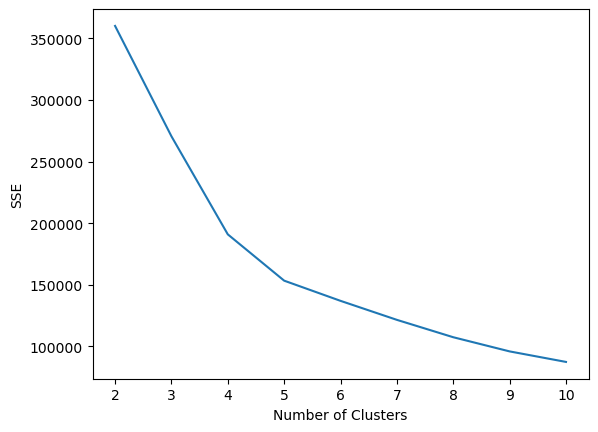

In [ ]:
# plot sse scores
plt.plot(range(2, 11), sse)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

2.2 Silhouette Score

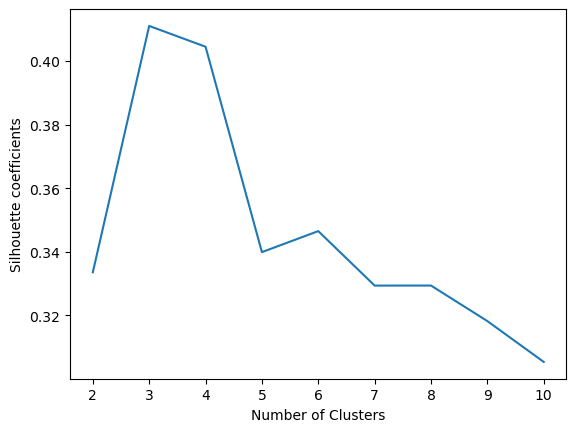

In [ ]:
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette coefficients")
plt.show()

Using both the graphs generated using the Elbow method and the Silhouette scores to determine K, 
we see that the elbow point seems to be at when k = 4, and the silhouette_score rapidly decreases after k = 4.

Therefore, the number of the clusters that will be used is k = 4.

In [89]:
clusters = KMeans(n_clusters=4, n_init = 10)
clusters.fit(complete_clusering_df)

# merged_anime_reviews_df['Cluster'] = clusters.labels_
# merged_anime_reviews_df.head()

complete_clusering_df['Cluster'] = clusters.labels_
complete_clusering_df.head()

,episodes,members,popularity,avg_rating,genre1_Comedy,genre2_ Sports,genre3_ Drama,genre4_ School,genre5_ Shounen,Overall,Story,Animation,Sound,Character,Enjoyment,Cluster
0,0.100574,0.35746,-0.59307,1.431616,1,1,1,1,1,7,7,9,8,8,8,1
1,0.100574,0.35746,-0.59307,1.431616,1,1,1,1,1,7,7,9,8,8,8,1
2,0.100574,0.35746,-0.59307,1.431616,1,1,1,1,1,7,7,9,8,8,8,1
3,0.100574,0.35746,-0.59307,1.431616,1,1,1,1,1,7,7,9,8,8,8,1
4,0.100574,0.35746,-0.59307,1.431616,1,1,1,1,1,7,7,9,8,8,8,1


In [90]:
complete_clusering_df.Cluster.value_counts()

0    81996
1    29275
2    15996
3     1994
Name: Cluster, dtype: int64

In [77]:
cluster0 = complete_clusering_df[complete_clusering_df['Cluster'] == 0].drop('Cluster',axis=1).mean()
cluster0.sort_values(ascending=False)[0:15]

Animation          9.000000
Sound              8.000000
Character          8.000000
Enjoyment          8.000000
Overall            7.000000
Story              7.000000
genre1_Comedy      1.000000
genre2_ Sports     1.000000
genre3_ Drama      1.000000
genre4_ School     1.000000
genre5_ Shounen    1.000000
avg_rating        -0.007039
episodes          -0.108231
popularity        -0.169900
members           -0.385129
dtype: float64

In [78]:
cluster1 = complete_clusering_df[complete_clusering_df['Cluster'] == 1].drop('Cluster',axis=1).mean()
cluster1.sort_values(ascending=False)[0:15]

Animation          9.000000
Sound              8.000000
Character          8.000000
Enjoyment          8.000000
Overall            7.000000
Story              7.000000
episodes           6.570641
members            1.114195
genre1_Comedy      1.000000
genre2_ Sports     1.000000
genre3_ Drama      1.000000
genre4_ School     1.000000
genre5_ Shounen    1.000000
avg_rating         0.588234
popularity        -0.528408
dtype: float64

In [79]:
cluster2 = complete_clusering_df[complete_clusering_df['Cluster'] == 2].drop('Cluster',axis=1).mean()
cluster2.sort_values(ascending=False)[0:15]

Animation          9.000000
Sound              8.000000
Character          8.000000
Enjoyment          8.000000
Overall            7.000000
Story              7.000000
popularity         2.106862
genre1_Comedy      1.000000
genre2_ Sports     1.000000
genre3_ Drama      1.000000
genre4_ School     1.000000
genre5_ Shounen    1.000000
episodes          -0.279480
members           -0.873510
avg_rating        -1.574400
dtype: float64

In [92]:
cluster3 = complete_clusering_df[complete_clusering_df['Cluster'] == 3].drop('Cluster',axis=1).mean()
cluster3.sort_values(ascending=False)[0:15]

Animation          9.000000
Sound              8.000000
Character          8.000000
Enjoyment          8.000000
Overall            7.000000
Story              7.000000
episodes           6.570641
members            1.114195
genre1_Comedy      1.000000
genre2_ Sports     1.000000
genre3_ Drama      1.000000
genre4_ School     1.000000
genre5_ Shounen    1.000000
avg_rating         0.588234
popularity        -0.528408
dtype: float64